In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import urllib.request
import os
import emcee
from time import time
import nestle
import corner
from astroML.plotting import plot_mcmc
from sklearn.neighbors import KernelDensity
from dynesty import NestedSampler

# for downloading 
def download(PATH,local_name,format_offile):
    '''This function takes PATH which is url of file and local_name i.e the name of file after downloaded and format
    file and downloads the file from web and stores in your path'''
    local_path=os.path.join("./",f'{local_name}.{format_offile}')
    urllib.request.urlretrieve(PATH,local_path)

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<p>Q1. Download the SPT fgas data from http://iith.ac.in/~shantanud/fgas_spt.txt. Fit the data to f0(1 + f1z) where f0 and f1 are unknown constants. Determine the best fit values of f0 and f1 including 68% and 90% credible intervals using emcee and corner.py. The priors on f0 and f1 should be 0 < f0 < 0.5 and −0.5 < f1 < 0.5.</p>

<p>I am ignoring the "ignore" field in the data to make problem easy.</p>

In [2]:
# downloading the dataset for this question
download("https://people.iith.ac.in/shantanud/fgas_spt.txt","fgas","txt")

In [3]:
datContent = [i.strip().split() for i in open("fgas.txt").readlines()] #Reading .dat file in python
i=0
datContent.pop(0)

z=np.array(datContent)[:,0]
z=z.astype(float)
fgas=np.array(datContent)[:,1]
fgas=fgas.astype(float)
fgas_error=np.array(datContent)[:,2]
fgas_error=fgas_error.astype(float)
ignore=np.array(datContent)[:,3]
ignore=ignore.astype(float)
# storing z,fgas,fgas_error and ignore values

In [4]:
def log_likelihood(theta, x, y, e):
    f0, f1 = theta
    y_model = f0*(1+f1*x)
    return -0.5 * np.sum(np.log(2*np.pi*e*e)+((y-y_model)/ e)**2)

In [5]:
def log_prior(theta):
    f0, f1 = theta
    if 0 < f0 < 0.5 and -0.5 < f1 < 0.5:
        return 0.0
    return -np.inf

In [6]:
def log_posterior(theta, z, fgas, e):
    if not np.isfinite(log_prior(theta)):
        return -np.inf
    return log_prior(theta) + log_likelihood(theta, z, fgas, e)

In [7]:
np.random.seed(10)
ndim,nwalkers=2,50
starting_guesses = np.random.rand(nwalkers, ndim) * np.array([0.5, 1.0]) + np.array([0.0, -0.5])
nsteps, nburn = 5000, 1000
sampler = emcee.EnsembleSampler(nwalkers,ndim,log_posterior,args=[z,fgas,fgas_error])
sampler.run_mcmc(starting_guesses, nsteps)
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2).T[:2]

<h3>68% and 90% credible regions</h3>

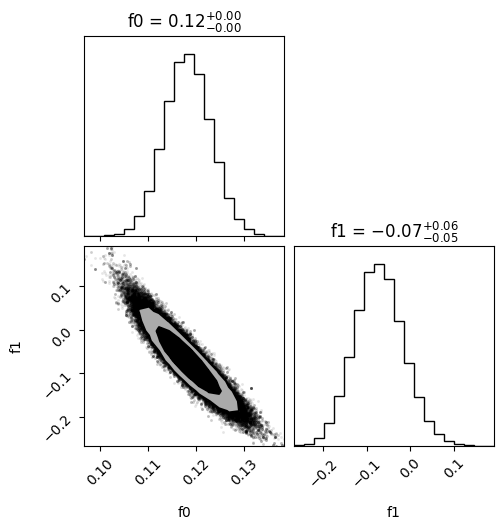

In [8]:
samples = sample.T

# Plot the posterior samples and contours
fig = corner.corner(samples, labels=["f0","f1"],show_titles=True,fill_contours=True,levels=[0.68,0.9])

# the above levels indicate 68% and 90% contours are being plotted
plt.show()

<p>From the above subplots consider bottom left plot, outer contour is representing 90% credible region and inner contour is 68% credible region.</p>

<h3>Using plot_mcmc</h3>

Text(0.5, 0.98, '68% and 90% credible regions using emcee and plot_mcmc')

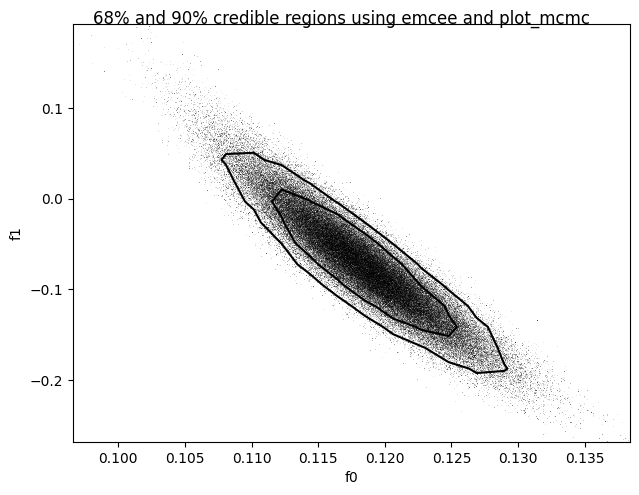

In [9]:
fig = plt.figure()
ax=plot_mcmc(sample,fig=fig,levels=[0.68,0.90],labels=["f0","f1"],colors='k')
ax[0].plot(sample[0,:], sample[1,:], ',k', alpha=0.1)
fig.suptitle("68% and 90% credible regions using emcee and plot_mcmc")

<p>From the above, outer contour is representing 90% credible region and inner contour is 68% credible region.</p>

In [10]:
f0,f1=np.mean(sample,axis=1)
print("Best fit value of f0 using mean of the emcee samples is",f0)
print("Best fit value of f1 using mean of the emcee samples is",f1)

Best fit value of f0 using mean of the emcee samples is 0.11826412928932119
Best fit value of f1 using mean of the emcee samples is -0.07165371211639666


<h3>Best fit parameters according to frequentist approach</h3>

In [11]:
def func(x,f0,f1):
    t=f1*f0
    return f0+t*x

popt, pcov = scipy.optimize.curve_fit(func, z, fgas, sigma=fgas_error)
# Print the best-fit values of f0 and f1
f0, f1 = popt
print("Best fit value of f0 is",f0)
print("Best fit value of f1 is",f1)

Best fit value of f0 is 0.11850231610228507
Best fit value of f1 is -0.07632971959287914


<p>From the above we can there is almost a match between our best fit values with frequentist approach and using emcee package.</p>

<p>Q2. Calculate the Bayes factor for the linear and quadratic model for the example given on fifth blog article of the Pythonic Perambulations Series using dynesty or Nestle. Do the values agree with what’s on the blog (obtained by integrating the emcee samples).?</p>

<h3>NOTE : </h3> 

These are prior and implementation dependent and I have choosen prior assuming data(x and y) is mostly in range (-1,2). For another prior you get different results.  I considered flat prior of 2*(theta)-1.

<h3>USING NESTLE</h3>

In [12]:
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data

In [13]:
def polynomial_fit(theta, x):
    return sum(t * x ** n for (n, t) in enumerate(theta))

In [14]:
def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

In [15]:
def prior_transform(theta):
    ''' As our data mostly contains between 2 and -1 mostly in positive side'''
    return 2*theta-1

In [16]:
np.random.seed(10)
t0=time()
linear = nestle.sample(logL, prior_transform,2)
t1=time()
print(f"log evidence of the linear model is {linear.logz}")
print(f"Program took {t1-t0} sec to run")

log evidence of the linear model is 16.207527453107303
Program took 2.502380847930908 sec to run


In [17]:
t0=time()
quadratic = nestle.sample(logL, prior_transform,3)
t1=time()
print(f"log evidence of the quadratic model is {quadratic.logz}")
print(f"Program took {t1-t0} sec to run")

log evidence of the quadratic model is 14.541687431812086
Program took 3.504255771636963 sec to run


In [18]:
# as we have same prior for both the models we considered so we have bayesian evidence same as exp(log(z1)-log(z2))
bayes_factor=np.exp(linear.logz-quadratic.logz)
print("Bayes factor of linear vs quadratic model using Nestle",bayes_factor)

Bayes factor of linear vs quadratic model using Nestle 5.290115193252486


<p>From the above we can clearly see there is difference in individual evidences from this to JVDP blog and Bayes factors from the blog and this is due to different type of sampling as nestle uses nestle sampling which is very different than MCMC sampling and different priors that we consider. This shows how prior is important in bayesian inferences and we don't have intuition to consider a particular prior which is biggest limitation of Bayesian.  Individual evidences in the  JVDP are almost 46942613 but we get exp(16.7) which is around 17894429 and bayes factor in that blog is around 2.36 but we get 5.3 here. Using jeffreys scale we can relate strength of evidence of quadratic over linear using bayes factor. According to jeffreys scale, we have quadratic is considerable over linear but according to nestle bayes factor it strongly favours linear model now.</p>

<h3>USING DYNESTY</h3>

In [19]:
np.random.seed(10)
tol=0.1
t0=time()
sampler = NestedSampler(logL, prior_transform,2,nlive=300,bound='multi')
sampler.run_nested(dlogz=tol, print_progress=False)
t1=time()
res = sampler.results # get results dictionary from sampler
linear_dynesty = res.logz[-1]  
print(f"log evidence of the linear model is {linear_dynesty}")
print(f"Program took {t1-t0} sec to run")

log evidence of the linear model is 15.668367619502154
Program took 26.962666511535645 sec to run


In [20]:
np.random.seed(10)
t0=time()
sampler = NestedSampler(logL, prior_transform,3,nlive=300,bound='multi')
sampler.run_nested(dlogz=tol, print_progress=False) 
res = sampler.results # get results dictionary from sampler
t1=time()
quadratic_dynesty = res.logz[-1]  
print(f"log evidence of the linear model is {quadratic_dynesty}")
print(f"Program took {t1-t0} sec to run")

log evidence of the linear model is 14.277719728169807
Program took 27.649983882904053 sec to run


In [21]:
# as we have same prior for both the models we considered so we have bayesian evidence same as exp(log(z1)-log(z2))
bayes_factor_dynesty=np.exp(linear_dynesty-quadratic_dynesty)
print("Bayes factor of linear vs quadratic model using Dynesty",bayes_factor_dynesty)

Bayes factor of linear vs quadratic model using Dynesty 4.017452082369333


<p>Q3. Download the SDSS quasar dataset from http://astrostatistics.psu.edu/datasets/SDSS_quasar.dat. Plot the KDE estimate of the quasar redshift distribution (the column with the title z) using a Gaussian and also an exponential kernel (with bandwidth=0.2) from -0.5 to 5.5.</p>

In [22]:
# downloading the dataset for this question
download("http://astrostatistics.psu.edu/datasets/SDSS_quasar.dat","SDSS_quasar","dat")

In [23]:
datContent = [i.strip().split() for i in open("SDSS_quasar.dat").readlines()] #Reading .dat file in python
i=0
datContent.pop(0)
z=np.array(datContent)[:,3]
z=z.astype(float).reshape(-1, 1)

x=np.linspace(-0.5,5.5,1000).reshape(-1, 1)

# getting Gaussian and Exponential kernel densities

gaussian_density=KernelDensity(kernel='gaussian',bandwidth=0.2).fit(z)
gaussian=np.exp(gaussian_density.score_samples(x))

exponential_density=KernelDensity(kernel='exponential',bandwidth=0.2).fit(z)
exponential=np.exp(exponential_density.score_samples(x))

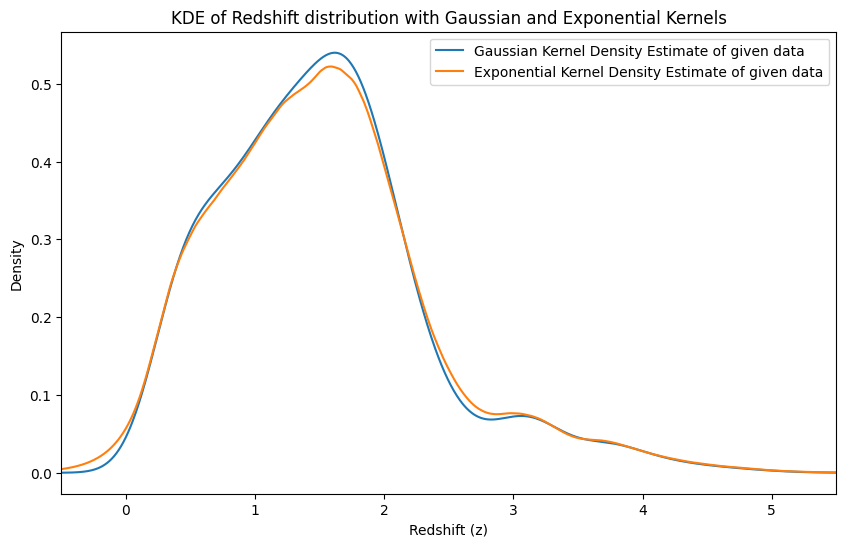

In [24]:
plt.figure(figsize=(10,6))
plt.plot(x,gaussian,label='Gaussian Kernel Density Estimate of given data')
plt.plot(x,exponential,label='Exponential Kernel Density Estimate of given data')
plt.xlim(-0.5, 5.5)
plt.title("KDE of Redshift distribution with Gaussian and Exponential Kernels")
plt.xlabel('Redshift (z)')
plt.ylabel('Density')
plt.legend()